In [1]:
import torch
import torch.nn as nn
#使用torchtext构建语料库，
from torchtext.legacy import data,datasets
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
#创建一些可以重复利用的随机种子
'''
torch.backends.cudnn.benchmark
简介：总的来说，大部分情况下，设置这个 flag 可以让内置的 cuDNN 的 auto-tuner 自动寻找最适合当前配置的高效算法，来达到优化运行效率的问题。
一般来讲，应该遵循以下准则：
如果网络的输入数据维度（包括 batch size，图片大小，输入的通道）或类型上变化不大，设置 torch.backends.cudnn.benchmark = true 可以增加运行效率；
如果网络的输入数据在每次 iteration 都变化的话，会导致 cnDNN 每次都会去寻找一遍最优配置，这样反而会降低运行效率。
'''
# SEED = 1234
# torch.manual_seed(SEED)
torch.backends.cudnn.deterministic=True
#使用spacy这个标记器将连续的字符串标记，不设置默认情况是将字符串拆分为空格，后面的language表示的是我们的使用的拆分模型
TEXT=data.Field(tokenize='spacy',tokenizer_language='en_core_web_sm')
Label=data.LabelField(dtype=torch.float)

In [3]:
train_data,test_data=datasets.IMDB.splits(TEXT,Label)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:06<00:00, 12.2MB/s]


In [4]:
import random
#可以通过split_ratio划分验证集的比例
train_data,valid_data=train_data.split(random_state=random.seed(1234))

In [5]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [6]:
#构建词汇表，有一个最大的数值25000（仅保留最常见的）
max_vocab_size=100000
TEXT.build_vocab(train_data,max_size=max_vocab_size)
Label.build_vocab(train_data)

In [7]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(Label.vocab)}")

Unique tokens in TEXT vocabulary: 100002
Unique tokens in LABEL vocabulary: 2


In [8]:
print(TEXT.vocab.freqs.most_common(10))
#通过itos，stoi直接查看词汇表
print(TEXT.vocab.itos[:10])
print(Label.vocab.stoi)

[('the', 202125), (',', 193002), ('.', 166119), ('and', 110200), ('a', 109507), ('of', 100808), ('to', 93707), ('is', 76272), ('in', 61485), ('I', 54813)]
['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']
defaultdict(None, {'neg': 0, 'pos': 1})


In [9]:
#最后一步：创建迭代器 BucketIterator 它是一种特殊类型的迭代器，它将返回一批示例，其中每个示例的长度相似，从而最小化每个示例的填充量。
Batch_size=64
train_iter,valid_iter,test_iter=data.BucketIterator.splits((train_data,valid_data,test_data),batch_size=Batch_size,device=device)

In [10]:
'''
下面是构建模型：__init__模块来构建神经网络的layer，
然后输入批次通过嵌入层进行嵌入，这为我们提供了句子的密集向量表示。 Embedded 是一个大小为 [sentence length, batch size, embedding dim] 的张量。
然后将嵌入的数据输入 RNN。 在某些框架中，您必须将初始隐藏状态 输入 RNN，但是在 PyTorch 中，如果没有将初始隐藏状态作为参数传递，则默认为全零张量。
RNN 返回 2 个张量，大小为 [sentence length, batch size, hidden dim] 的输出和大小为 [1, batch size, hidden dim] 的隐藏。 输出是每个时间步的隐藏状态的串联，而隐藏只是最终的隐藏状态。 我们使用 assert 语句来验证这一点。 请注意挤压方法，该方法用于删除大小为 1 的维度。
最后，我们通过线性层 fc 提供最后一个隐藏状态 hidden 以产生预测。
'''
class RNN(nn.Module):
    def __init__(self,input_dim,embedding_dim,hidden_dim,output_dim):
        super().__init__()
        #通过嵌入层将稀疏的独热向量转化为dense向量
        self.embedding=nn.Embedding(input_dim,embedding_dim)
        self.rnn=nn.RNN(embedding_dim,hidden_dim)
        self.fc=nn.Linear(hidden_dim,output_dim)
    def forward(self,text):
        #输入层的维度是独热向量的维度，同词汇表的size相同
        embedded=self.embedding(text)
        #嵌入层的维度即是dense word vector的size，通常在50-250之间，取决于词汇表的大小
        output,hidden=self.rnn(embedded)
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        #rnn返回两个值是output表示的是每个时间段的隐藏的串联，hidden是最终的隐藏状态，我们使用assert来进行验证，相等则继续执行
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        return self.fc(hidden.squeeze(0))

In [11]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model.to(device)

RNN(
  (embedding): Embedding(100002, 100)
  (rnn): RNN(100, 256)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [12]:
'''
训练模型：
1、首先是将计算图中的梯度归零
2、从loss函数中计算网络中的损失
3、使用梯度来更新网络参数
'''
import torch.optim as optim
optimizer=optim.Adam(model.parameters())
lossfunction=nn.BCEWithLogitsLoss()

In [13]:
# #将我们的模型和损失函数放到GPU上

lossfunction=lossfunction.to(device)

In [14]:
#计算accuracy
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [15]:
def train(model,iterator,optimizer,lossfunction,progress):
    epoch_loss=0
    epoch_acc=0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        prediction=model(batch.text).squeeze(1)
        loss=lossfunction(prediction,batch.label)
        acc=binary_accuracy(prediction,batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        progress.append(loss.item())
    return epoch_loss / len(iterator), epoch_acc / len(iterator),progress

In [16]:
from tqdm import tqdm
n_epoch=5
progress=[]
for epoch in tqdm(range(n_epoch)):
    loss,acc,progress=train(model,train_iter,optimizer,lossfunction,progress)
    print(f'\tTrain Loss: {loss:.3f} | Train Acc: {acc*100:.2f}%')




 20%|██        | 1/5 [00:17<01:11, 17.80s/it]

	Train Loss: 0.702 | Train Acc: 49.97%


 40%|████      | 2/5 [00:34<00:52, 17.37s/it]

	Train Loss: 0.698 | Train Acc: 50.23%


 60%|██████    | 3/5 [00:51<00:34, 17.02s/it]

	Train Loss: 0.697 | Train Acc: 50.02%


 80%|████████  | 4/5 [01:08<00:16, 17.00s/it]

	Train Loss: 0.697 | Train Acc: 50.29%


100%|██████████| 5/5 [01:25<00:00, 17.06s/it]

	Train Loss: 0.697 | Train Acc: 49.88%


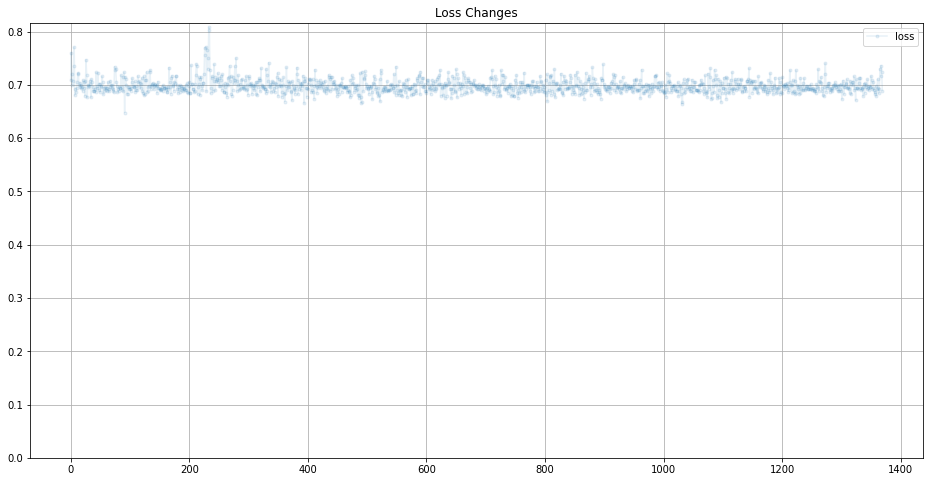

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_progress(progress):
        df = pd.DataFrame(progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True)
        plt.title('Loss Changes')
plot_progress(progress)